# Fraud case study



## Day 1: building a fraud model

## Day 2: building an app/dashboard

## Tips success

You will quickly run out of time:

*  Use CRISP-DM workflow to analyze data and build a model
*  Iterate quickly, test often, commit often
*  Build deadlines for your work so you stay on track
*  Should have a model by end of day 1
*  Start app once model is working

### CRISP-DM workflow

Follow the [CRISP-DM](https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining) steps:

1.  Business understanding
2.  Data understanding
3.  Data preparation
4.  Modeling
5.  Evaluation
6.  Deployment

# Introduction to case study: data & problem

Let's look at the data.  What format is the data in?  How do you extract it?

In [1]:
ls -lh data

total 67280
-rw-r--r--  1 jbud  staff    33M May 27 20:23 data.zip


Unzip the data so you can load it into Python

In [2]:
!unzip data/data.zip -d data

Archive:  data/data.zip
  inflating: data/data.json          


Initially, work with a subset at first in order to iterate quickly.  But, the file is one giant line of json:

In [3]:
!wc data/data.json

       0 8173151 250481668 data/data.json


Write a quick and dirty script to pull out the first 100 records so we can get code working quickly.

In [4]:
%%writefile subset_json.py
"""head_json.py - extract a couple records from a huge json file.

Syntax: python head_json.py < infile.json > outfile.json
"""

import sys

start_char = '{'
stop_char = '}'
n_records = 100
level_nesting = 0

while n_records != 0:
    ch = sys.stdin.read(1)
    sys.stdout.write(ch)
    if ch == start_char:
        level_nesting += 1
    if ch == stop_char:
        level_nesting -= 1
        if level_nesting == 0:
            n_records -= 1
sys.stdout.write(']')


Writing subset_json.py


In [5]:
!python subset_json.py < data/data.json > data/subset.json

In [5]:
import pandas as pd

df = pd.read_json('data/subset.json')

In [55]:
df.info

<bound method DataFrame.info of           acct_type  approx_payout_date  body_length  channels country  \
0   fraudster_event          1266062400         3852         5      US   
1           premium          1296720000         3499         0      US   
2           premium          1296172800         2601         8      US   
3           premium          1388966400        12347         6      IE   
4           premium          1297900800         2417        11      US   
..              ...                 ...          ...       ...     ...   
95          premium          1328070600         1314         6      US   
96          premium          1324098000         1483         6      US   
97          premium          1325844000         1860         5      US   
98          premium          1325836500         2219        11      US   
99          premium          1357466400        12479         8      US   

   currency  delivery_method  \
0       USD                0   
1       USD    

In [56]:
df.head().T

,0,1,2,3,4
acct_type,fraudster_event,premium,premium,premium,premium
approx_payout_date,1266062400,1296720000,1296172800,1388966400,1297900800
body_length,3852,3499,2601,12347,2417
channels,5,0,8,6,11
country,US,US,US,IE,US
currency,USD,USD,USD,EUR,USD
delivery_method,0,1,1,1,0
description,"<p><a href=""http://s432.photobucket.com/albums...","<p>Join us for a quick, one-night, community-b...","<h3><span class=""subcategory""><strong>Teacher ...","<p style=""margin-bottom: 1.3em; padding-bottom...",<p>Writers and filmmakers need to understand t...
email_domain,gmail.com,ruf.org,pvsd.k12.ca.us,irishtabletennis.com,artsandbusinesscouncil.org
event_created,1262739706,1293832670,1291090956,1360681570,1291994666


Some of the data is text (and HTML), which will require feature engineering:

* TF-IDF
* Feature hashing
* n-grams

etc.

You will also need to construct a target from `acct_type`.  Fraud events start with `fraud`.  How you define fraud depends on how you define the business problem.

In [12]:
df.acct_type.value_counts(dropna=False)

premium             90
fraudster            3
spammer_warn         3
fraudster_event      2
spammer_noinvite     1
spammer_limited      1
Name: acct_type, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 44 columns):
acct_type             100 non-null object
approx_payout_date    100 non-null int64
body_length           100 non-null int64
channels              100 non-null int64
country               100 non-null object
currency              100 non-null object
delivery_method       100 non-null int64
description           100 non-null object
email_domain          100 non-null object
event_created         100 non-null int64
event_end             100 non-null int64
event_published       100 non-null int64
event_start           100 non-null int64
fb_published          100 non-null int64
gts                   100 non-null float64
has_analytics         100 non-null int64
has_header            90 non-null float64
has_logo              100 non-null int64
listed                100 non-null object
name                  100 non-null object
name_length           100 non-null int64
num_order             100

Is missing data a problem?  What are your options for handling missing data?

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
approx_payout_date,100.0,1.314867e+09,1.455055e+07,1.266062e+09,1.304711e+09,1.315984e+09,1.322812e+09,1.388966e+09
body_length,100.0,3.114250e+03,2.814620e+03,0.000000e+00,1.077500e+03,1.920500e+03,4.361000e+03,1.247900e+04
channels,100.0,7.500000e+00,3.195641e+00,0.000000e+00,5.750000e+00,8.000000e+00,1.100000e+01,1.300000e+01
delivery_method,100.0,4.600000e-01,6.100174e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
event_created,100.0,1.309823e+09,1.272655e+07,1.262740e+09,1.300009e+09,1.310730e+09,1.318629e+09,1.360682e+09
event_end,100.0,1.314436e+09,1.455050e+07,1.265630e+09,1.304279e+09,1.315552e+09,1.322380e+09,1.388534e+09
event_published,100.0,1.310264e+09,1.282619e+07,1.263110e+09,1.300033e+09,1.312086e+09,1.318995e+09,1.360683e+09
event_start,100.0,1.314038e+09,1.330579e+07,1.265594e+09,1.304267e+09,1.315433e+09,1.321645e+09,1.360703e+09
fb_published,100.0,2.000000e-01,4.020151e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
gts,100.0,2.223905e+03,5.168755e+03,0.000000e+00,9.998500e+01,5.595900e+02,1.451150e+03,3.896353e+04


In [15]:
df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,premium,1328070600,1314,6,US,USD,0,<h3>Jan 26 at 7pm</h3>\r\n<h4>Opening Night Ga...,nwfilmforum.org,1322877746,...,"[{'event_id': 2589534, 'cost': 38.0, 'availabi...",211,1304619530,3,1515 12th Avenue,US,47.614380,-122.317031,Northwest Film Forum,WA
96,premium,1324098000,1483,6,US,USD,0,"<p> </p>\r\n<div style=""text-align: -webkit-au...",richmondicezone.com,1322879399,...,"[{'event_id': 2589614, 'cost': 8.0, 'availabil...",682,1263930774,4,4350 Pouncey Tract Road,US,37.654891,-77.613550,SkateNation Plus,VA
97,premium,1325844000,1860,5,US,USD,1,"<p style=""text-align: center;""><span style=""fo...",kineticevents.com,1323477465,...,"[{'event_id': 2621588, 'cost': 20.0, 'availabi...",359,1292438475,1,138 Minna St.,US,37.786823,-122.400339,John Colins,CA
98,premium,1325836500,2219,11,US,USD,1,"<p style=""font-size: 10pt;"" align=""left""><img ...",cecnc.com,1325106030,...,"[{'event_id': 2687671, 'cost': 0.0, 'availabil...",919,1245718455,3,111 Minna St,US,37.787429,-122.399384,111 Minna Gallery,CA


In [21]:
df.columns

Index(['acct_type', 'approx_payout_date', 'body_length', 'channels', 'country',
       'currency', 'delivery_method', 'description', 'email_domain',
       'event_created', 'event_end', 'event_published', 'event_start',
       'fb_published', 'gts', 'has_analytics', 'has_header', 'has_logo',
       'listed', 'name', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter',
       'payee_name', 'payout_type', 'previous_payouts', 'sale_duration',
       'sale_duration2', 'show_map', 'ticket_types', 'user_age',
       'user_created', 'user_type', 'venue_address', 'venue_country',
       'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state'],
      dtype='object')

In [12]:
column_subset = ['acct_type','has_analytics', 'has_header', 'has_logo',
       'listed', 'name', 'name_length', 'num_order', 'num_payouts',
       'object_id', 'org_desc', 'org_facebook', 'org_name', 'org_twitter',
       'payee_name', 'payout_type']

In [6]:
df['acct_type'].unique()

array(['fraudster_event', 'premium', 'spammer_warn', 'fraudster',
       'spammer_limited', 'spammer_noinvite'], dtype=object)

In [7]:
df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,premium,1328070600,1314,6,US,USD,0,<h3>Jan 26 at 7pm</h3>\r\n<h4>Opening Night Ga...,nwfilmforum.org,1322877746,...,"[{'event_id': 2589534, 'cost': 38.0, 'availabi...",211,1304619530,3,1515 12th Avenue,US,47.614380,-122.317031,Northwest Film Forum,WA
96,premium,1324098000,1483,6,US,USD,0,"<p> </p>\r\n<div style=""text-align: -webkit-au...",richmondicezone.com,1322879399,...,"[{'event_id': 2589614, 'cost': 8.0, 'availabil...",682,1263930774,4,4350 Pouncey Tract Road,US,37.654891,-77.613550,SkateNation Plus,VA
97,premium,1325844000,1860,5,US,USD,1,"<p style=""text-align: center;""><span style=""fo...",kineticevents.com,1323477465,...,"[{'event_id': 2621588, 'cost': 20.0, 'availabi...",359,1292438475,1,138 Minna St.,US,37.786823,-122.400339,John Colins,CA
98,premium,1325836500,2219,11,US,USD,1,"<p style=""font-size: 10pt;"" align=""left""><img ...",cecnc.com,1325106030,...,"[{'event_id': 2687671, 'cost': 0.0, 'availabil...",919,1245718455,3,111 Minna St,US,37.787429,-122.399384,111 Minna Gallery,CA


In [8]:
df = pd.read_json('data/subset.json')

In [50]:
#Payout date - relation to 

def is_fraud(df, col):
    '''
    Replaces fraud with 1 for true, 0 for false
    '''
    fraud_descriptors = ['fraudster_event', 'fraudster']
    df[col] = df[col].apply(lambda x: x in fraud_descriptors)
    df[col].replace(True, int(1), inplace = True)
    return df

In [68]:
df

,org_name,name_length,event_end,venue_latitude,event_published,user_type,channels,currency,org_desc,event_created,...,sale_duration,num_payouts,name,country,delivery_method,has_analytics,fb_published,venue_state,has_header,show_map
0,DREAM Project Foundation,51,1363928400,42.963058,1361978554,1,11,USD,,1361291193,...,22,0,DREAM Project Foundation - Taste of a Better F...,US,0,0,0,MI,NaN,1


In [67]:
is_fraud(df, 'acct_type')

KeyError: 'acct_type'

In [15]:
mycols_df = df[column_subset]

In [87]:
#make sure have values in test data - sam sent out link
'''
'has_analytics' - yes - 1 or 0
'has_header' - yes - some missing , drop or replace with zero or unknown?
'has_logo' - yes
'listed' - yes
'name' - yes
'name_length' - yes
'num_order' - yes
'num_payouts' - yes
'object_id' - yes
'org_desc' - yes, but empty
'org_facebook' - yes
'org_name' - yes
'org_twitter' - yes
'payee_name' - yes, but empty 
'payout_type' - yes
'''
print('test')

test


In [16]:
# %load src/build_model.py
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import dump
import pickle

from src.feature_engineering import clean_pipeline

def roc():
    # Plot the ROC curve
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
            label='Luck')
    ax.plot(fpr, tpr, color='b', lw=2, label='Model')
    ax.set_xlabel("False Positive Rate", fontsize=20)
    ax.set_ylabel("True Postive Rate", fontsize=20)
    ax.set_title("ROC curve", fontsize=24)
    ax.text(0.3, 0.7, " ".join(["AUC:",str(auc.round(3))]), fontsize=20)
    ax.legend(fontsize=24)
    plt.show()

def random_search(X_train,y_train):
    #random search params
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train, y_train)

    print(rf_random.best_params_)
    # {'classifier__n_estimators': 368, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': None, 'classifier__bootstrap': False}

def update_df_with_new(df):
    '''
    Update current df with new data from app feature?
    '''
    pass

if __name__ == "__main__":

    # Every column in this list will be one-hot-encoded
    one_hot_cols = [
        "domain_country_code",
        "delivery_method",
        "payout_type",
        "currency"
    ]

    # Assemble pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(), 'description'),
            ('category', OneHotEncoder(handle_unknown='ignore'), one_hot_cols),
        ],
    )
    pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', RandomForestClassifier(n_estimators=368, min_samples_split=2, max_features='sqrt', bootstrap=False)),
        ]
    )
  
    # Load in data
    total_df = pd.read_json('data/data.json')

    # Run whole data through feature engineering pipeline
    clean_df = clean_pipeline(total_df)

    # Split X and y
    X = clean_df.drop(["target"], axis=1)
    y = clean_df["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, stratify=y)

    # Fit training data to pipeline
    pipe.fit(X_train, y_train)
    
    # Get probailities of fraud
    probs = pipe.predict_proba(X_test)[:, 1]

    # Make predictions based on specified threshold
    threshold = 0.15
    y_hat = (probs >= threshold).astype(int)

    # Evaluate model
    tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()

    print(pd.DataFrame({
        "pred:fraud": [tp, fp],
        "pred:not_fraud": [fn, tn]
    }, index=['actual:fraud', 'actual:not_fraud']))

    class_rept_dict = classification_report(y_test, y_hat, output_dict=True) 
    class_rept_df = pd.DataFrame(class_rept_dict).transpose()
    print(class_rept_df)

    fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
    auc = roc_auc_score(y_test, probs)
    print("AUC:", auc)

    # Fit on whole dataset and save model
    pipe.fit(X, y)
    train_columns = list(X.columns)
    with open('models/column_list.pkl', 'wb') as f:
        pickle.dump(train_columns, f)
    dump(pipe, 'models/randomforest.joblib')


                  pred:fraud  pred:not_fraud
actual:fraud             223             100
actual:not_fraud         152            3110
              precision    recall  f1-score      support
0              0.968847  0.953403  0.961063  3262.000000
1              0.594667  0.690402  0.638968   323.000000
accuracy       0.929707  0.929707  0.929707     0.929707
macro avg      0.781757  0.821903  0.800016  3585.000000
weighted avg   0.935135  0.929707  0.932043  3585.000000
AUC: 0.9352217959693477


In [12]:
ls

Directions.md                 for_instructors/
Dockerfile                    images/
FraudCaseStudyOverview.ipynb  model_notes.md
JacobEDA.ipynb                models/
Pickle.ipynb                  pair.md
app.py                        readme.md
data/                         requirements.txt
example.json                  src/
example_app.py                subset_json.py


In [19]:
# %load src/feature_engineering.py
import re
import pandas as pd
from bs4 import BeautifulSoup
import pickle
import numpy as np


def is_fraud(string):
    if re.match("fraud", string):
        return 1
    else:
        return 0


def remove_html_tags(html_string):
    soup = BeautifulSoup(html_string, features="lxml")
    return soup.get_text()


def get_domain_country_code(domain):
    return re.sub(r"^[^\.]+?(\..+$)", r"\1", domain)


def prev_payout_bool(prev_payout_list):
    if len(prev_payout_list) == 0:
        return 0
    else:
        return 1


def suspicious_age(age):
    if age == 0 or age == None:
        return 1
    else:
        return 0


def org_booleans(org_int):
    if org_int == 0:
        return 1
    else:
        return 0

def user_type(user):
    if user == 1:
        return 1
    else:
        return 0

def has_delivery_method(delivery_method):
    if delivery_method == np.nan or delivery_method == 0 or delivery_method == None:
        return 0
    else:
        return 1

def has_org_name(org_name):
    if org_name == np.nan or org_name == None or org_name == "":
        return 0
    else:
        return 1


def drop_cols(df, list_of_cols):
    return df.drop(labels=list_of_cols)


def clean_pipeline(original_df):
    '''
    Applies all the functions outlined above
    '''
    df = original_df.copy()
    if 'acct_type' in df.columns:
        df['target'] = df['acct_type'].apply(is_fraud)
    df['description'] = df['description'].apply(remove_html_tags)
    df['domain_country_code'] = df['email_domain'].apply(get_domain_country_code)
    df['previous_payouts'] = df['previous_payouts'].apply(prev_payout_bool)
    df['suspicious_age'] = df['user_age'].apply(suspicious_age)
    df['org_twitter'] = df['org_twitter'].apply(org_booleans)
    df['org_facebook'] = df['org_facebook'].apply(org_booleans)
    df['delivery_method'] = df['delivery_method'].astype(str)
    df['has_org_name'] = df['org_name'].apply(has_org_name)
    df['has_payee_name'] = df['payee_name'].apply(has_org_name)
    df['venue_latitude'] = df['venue_latitude'].fillna(0)
    df['has_coords'] = (df['venue_latitude'] != 0).astype(int)
    df['match_country'] = (df['country'] == df['venue_country']).astype(int)
    df['event_length'] =  df['event_end'] - df['event_start']
    df['user'] = df['user_type'].apply(user_type)

    # Every column in this list will be dropped
    drop_cols = [
        "acct_type",
        "email_domain",
        "venue_state",
        "venue_name",
        "user_age",
        "has_header",
        "event_end",
        "event_start",
        "event_created",
        "event_published",
        "gts",
        "sale_duration",
        "sale_duration2",
        "venue_latitude",
        "venue_longitude",
        "object_id",
        "user_type",
        "approx_payout_date",
        "user_created",
        "listed",
        "num_payouts",
        # maybe tfidf?
        "org_desc",
        "org_name",
        "name",
        "name_length",
        "country",
        "venue_country",
        "venue_address",
        # maybe mess with this
        "ticket_types",
        "payee_name"
    ]

    df.drop(labels=drop_cols, axis=1, inplace=True, errors='ignore')

    return df

if __name__ == "__main__":
    df = pd.read_json('data/data.json')
    clean_df = clean_pipeline(df)


In [21]:
# %load src/predict.py
from joblib import load
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import json

from src.feature_engineering import clean_pipeline

def predict_one(datapoint_df):
    # Load in model that was created in build_model.py
    pipe = load("models/randomforest.joblib")
    
    # Load training data columns to match structure before running through the pipeline
    with open('models/column_list.pkl', 'rb') as f:
        train_columns = pickle.load(f)

    # Load example data point

    # Run through feature engineering pipeline
    df_clean = clean_pipeline(datapoint_df)

    # Add columns from original training data to match the structure
    df_clean_structured = pd.DataFrame(df_clean, columns=train_columns)

    # Get probability of fraud
    probs = pipe.predict_proba(df_clean_structured)[:, 1]

    # Make prediction based on a specified threshold
    threshold = 0.15
    y_hat = (probs >= threshold).astype(int)

    return probs[0], y_hat[0]

if __name__ == "__main__":
    df = pd.read_json('example.json')
    print(predict_one(df))

(0.04619565217391304, 0)


In [22]:
df_clean

NameError: name 'df_clean' is not defined

In [62]:
total_df = pd.read_json('data/data.json')

In [63]:
total_df['acct_type'] = is_fraud(total_df, 'acct_type')
       

In [57]:
total_df['acct_type'].replace({True: 1}, inplace = True)
total_df['acct_type'].replace({False: 0}, inplace = True)

In [64]:
total_df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,1,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,0,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,0,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,0,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,0,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,1,1361689200,667,0,US,USD,0.0,<p>Celebrates this wonderful holiday with the ...,yahoo.com,1360297993,...,"[{'event_id': 5456442, 'cost': 45.0, 'availabi...",0,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD
14333,0,1365566400,5812,5,US,USD,1.0,"<table style=""width: 600px;"" border=""0"" cellsp...",me.com,1360367042,...,"[{'event_id': 5465112, 'cost': 90.0, 'availabi...",1374,1241625346,4,1775 E Mission Bay Dr,US,32.778906,-117.209791,Hilton San Diego Resort and Spa (Hilton Missio...,CA
14334,0,1368781200,557,13,,USD,0.0,<p>What a way to start off your Mother's Day l...,yahoo.com,1360600330,...,"[{'event_id': 5465732, 'cost': 20.0, 'availabi...",84,1353386971,4,5991 Bullard Road,US,30.041819,-89.957130,Fleur De Lis Ballroom NUMBER 2,LA
14335,0,1361361600,10873,8,US,USD,0.0,"<p style=""font-family: 'Helvetica Neue', Helve...",velvetlist.com,1360376285,...,"[{'event_id': 5465810, 'cost': 79.33, 'availab...",812,1290204991,3,2297 Cedar Ave,US,40.862283,-73.911363,Salsa con fuego,NY


In [44]:
'''
Dropped cols:
Assumed not to have siginificant relevance to Fraud and/or would have to be one hot encoded into too many different features:

venue state
venue name
has header
sale_duration, sale_duration2
Venue_latitude, Venue longitude
Venue address*
name_length
name
object_id
listed
num_payouts* (maybe tfidf)
"org_desc",
"org_name",
"ticket_types",

Redundant with other features:
Venue_country
country


Unclear what the numbers represent:
gts
approx_payout_date
user_created

Target value:
acct_type

Feature Engineered:
User Age : Changed to binary - 0 or not
event_end, event_start, event_published, event_created - Changed into event length
Email Domain - Used as country code
*Possibly reconsider if more time allows
payee name : Whether a name is specified or not
user type - converted to binary, whether 1 or not (highly correlated with fraud)
'''
total_df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,fraudster_event,1361689200,667,0,US,USD,0.0,<p>Celebrates this wonderful holiday with the ...,yahoo.com,1360297993,...,"[{'event_id': 5456442, 'cost': 45.0, 'availabi...",0,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD
14333,premium,1365566400,5812,5,US,USD,1.0,"<table style=""width: 600px;"" border=""0"" cellsp...",me.com,1360367042,...,"[{'event_id': 5465112, 'cost': 90.0, 'availabi...",1374,1241625346,4,1775 E Mission Bay Dr,US,32.778906,-117.209791,Hilton San Diego Resort and Spa (Hilton Missio...,CA
14334,premium,1368781200,557,13,,USD,0.0,<p>What a way to start off your Mother's Day l...,yahoo.com,1360600330,...,"[{'event_id': 5465732, 'cost': 20.0, 'availabi...",84,1353386971,4,5991 Bullard Road,US,30.041819,-89.957130,Fleur De Lis Ballroom NUMBER 2,LA
14335,tos_warn,1361361600,10873,8,US,USD,0.0,"<p style=""font-family: 'Helvetica Neue', Helve...",velvetlist.com,1360376285,...,"[{'event_id': 5465810, 'cost': 79.33, 'availab...",812,1290204991,3,2297 Cedar Ave,US,40.862283,-73.911363,Salsa con fuego,NY


In [45]:
from pandas.plotting import scatter_matrix

In [61]:
total_df['acct_type'].unique()

array([0])

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])
/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:95: RuntimeWarning: invalid value encountered in true_divide
  adj = (locs - lim1[0]) / (lim1[1] - lim1[0])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a9a1f9668>,
      dtype=object)

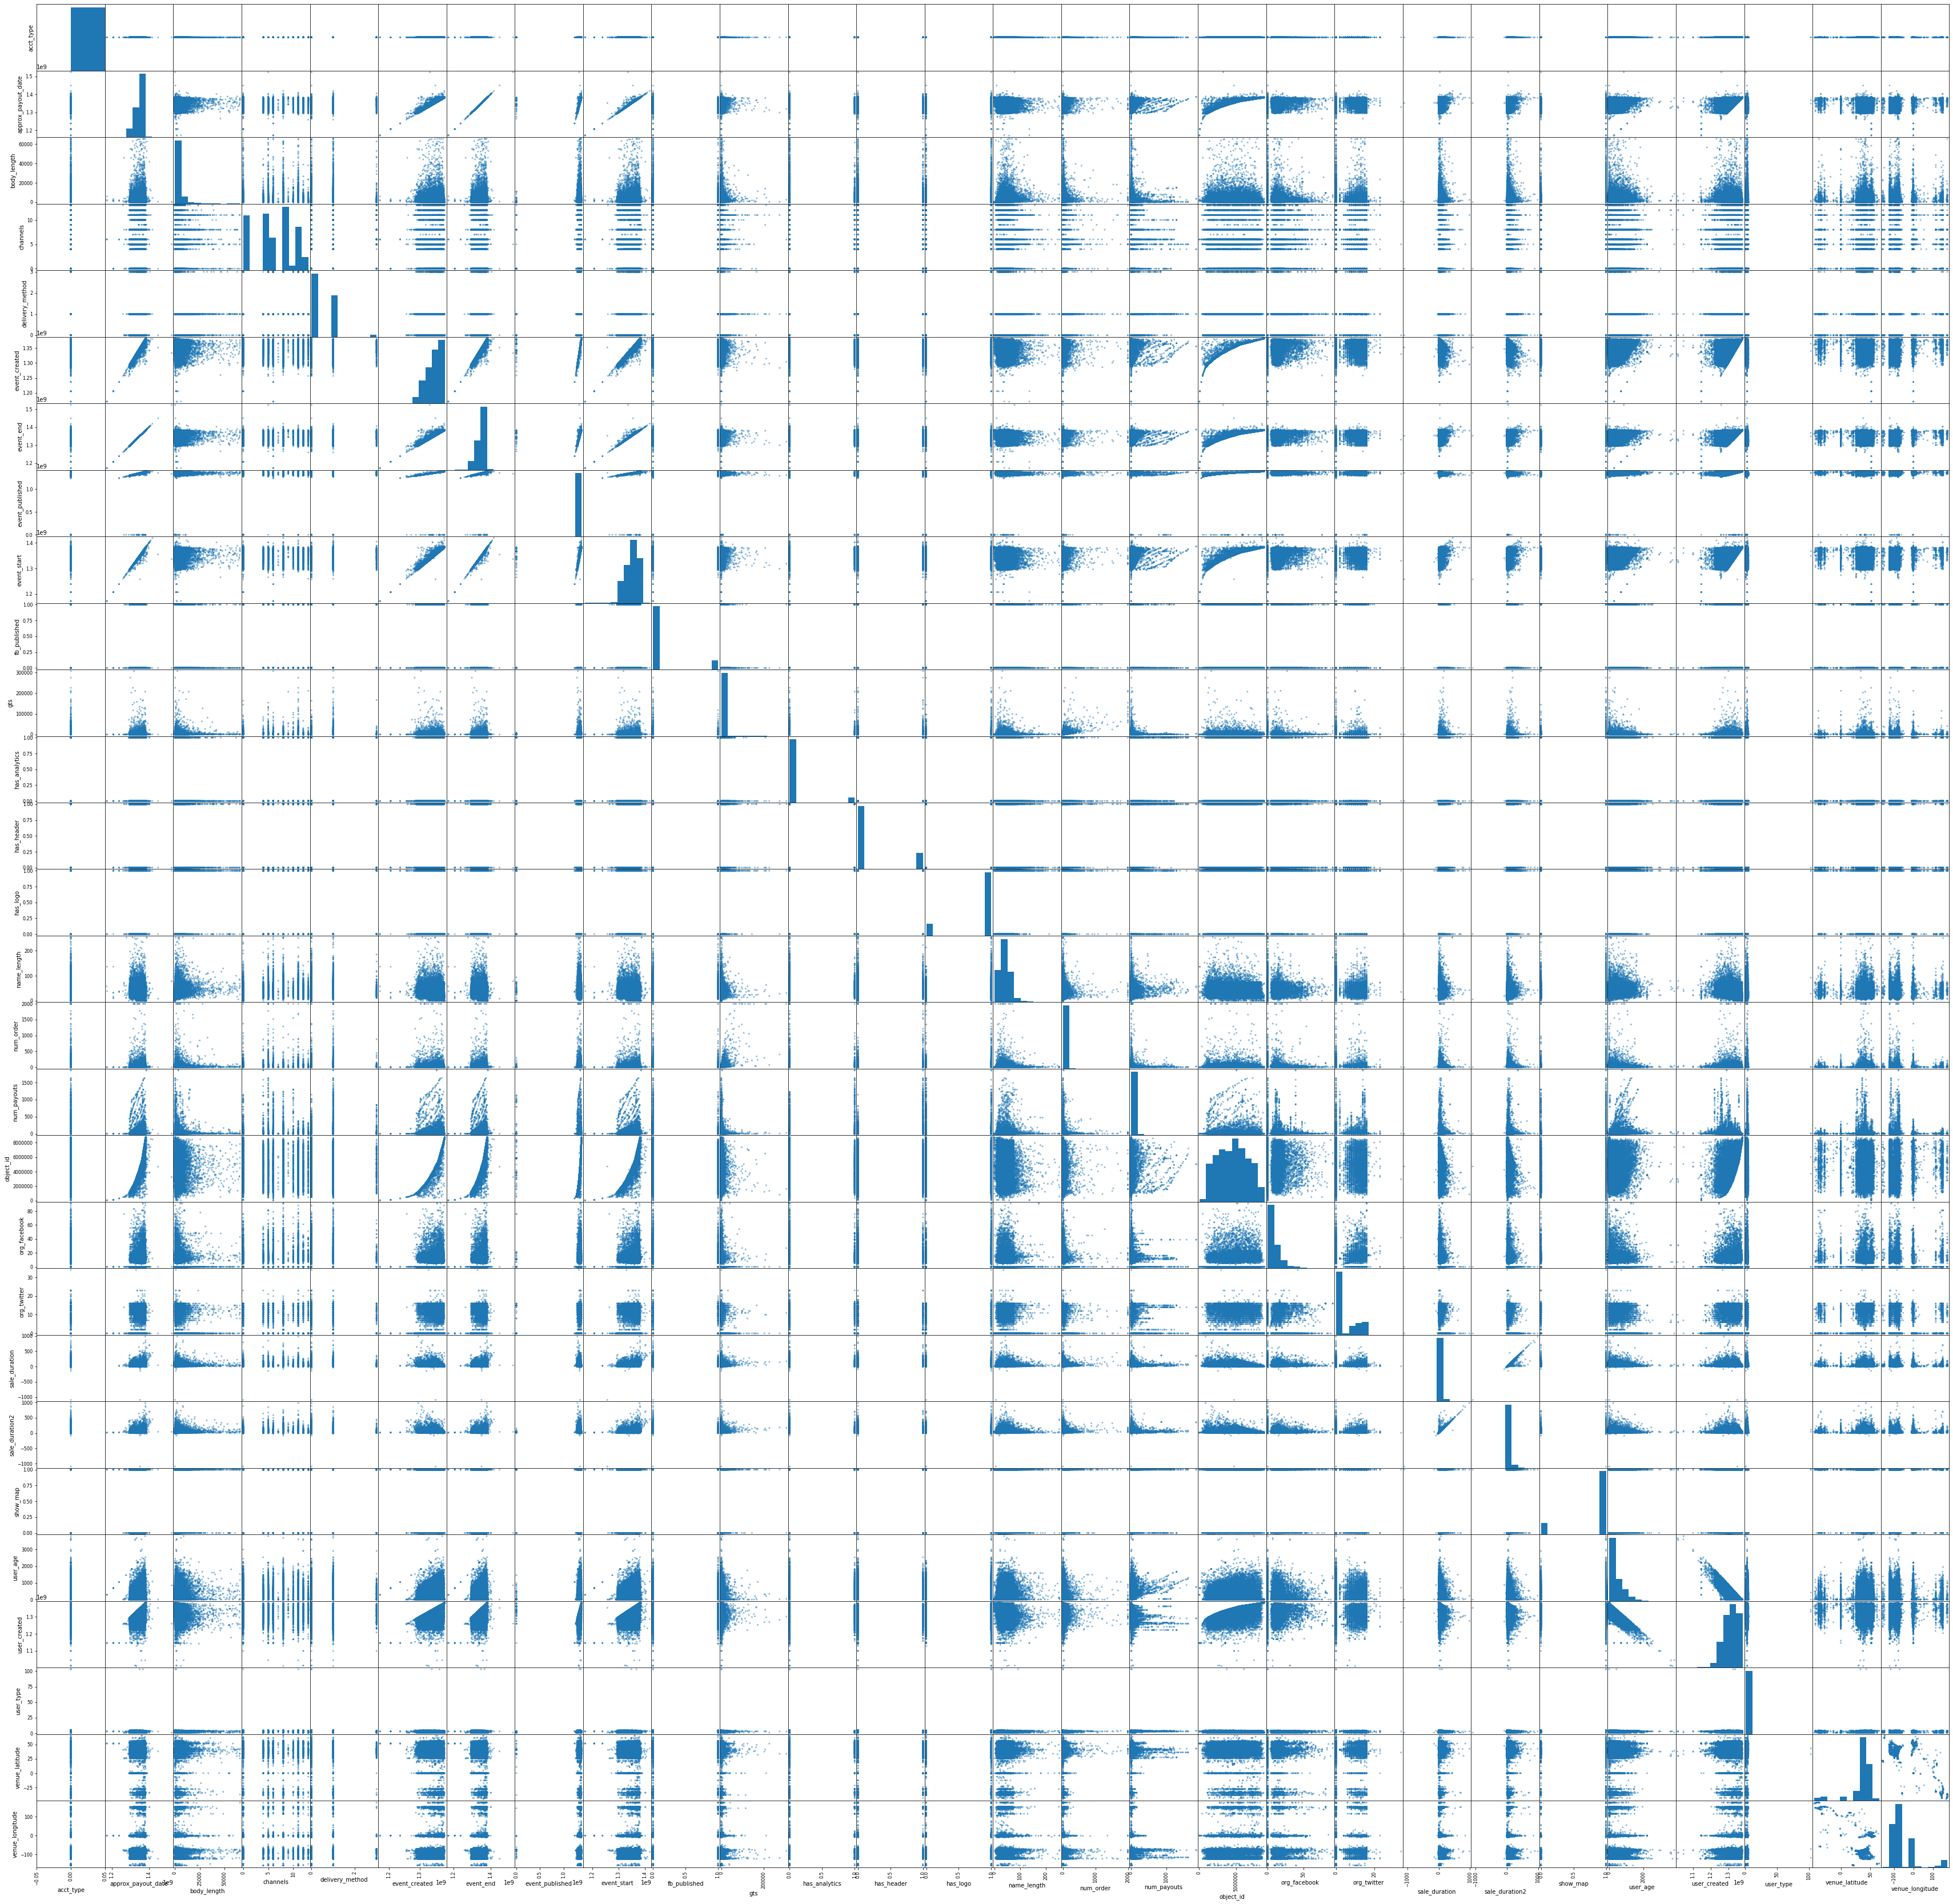

In [60]:
scatter_matrix(total_df, figsize = (60, 60))

In [43]:
total_df.iloc[:5,10:30]

,event_end,event_published,event_start,fb_published,gts,has_analytics,has_header,has_logo,listed,name,name_length,num_order,num_payouts,object_id,org_desc,org_facebook,org_name,org_twitter,payee_name,payout_type
0,1265630400,1.263110e+09,1265594400,0,0.00,0,1.0,0,y,"99 HOUR ""NO SLEEP"" SUPER BOWL CELEBRITY WEEKEN...",60,0,0,527017,,0.0,Party Starz Ent & Diverse Int'l Group,0.0,,
1,1296288000,1.293833e+09,1296255600,0,868.02,0,0.0,1,n,Winthrop RUF Winter Getaway,27,23,1,786878,"<p>Since 1987, RUF has ministered to students ...",0.0,RUF at Winthrop University,12.0,RUF,CHECK
2,1295740800,1.291092e+09,1295713800,0,3500.00,0,NaN,0,y,DRDP (2010) Teacher Training,28,19,4,787337,"<p><a href=""http://www.desiredresults.com"">www...",0.0,University Preparation School in collaboration...,0.0,University Preparation School,CHECK
3,1388534400,1.360683e+09,1360702800,0,1167.35,0,0.0,1,y,ITTA Affiliation 2013,21,39,16,885645,,0.0,,0.0,,ACH
4,1297468800,1.291995e+09,1297440000,1,2313.15,0,0.0,0,y,Self Defense for Writers and Filmmakers: For A...,66,30,0,1114349,"<p><font face=""Arial""><font size=""2""><strong>T...",0.0,Arts & Business Council of Greater Boston,0.0,Arts and Business Council or Greater Boston,CHECK


In [38]:
total_df.loc['listed']

KeyError: 'listed'

In [40]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14337 entries, 0 to 14336
Data columns (total 44 columns):
acct_type             14337 non-null object
approx_payout_date    14337 non-null int64
body_length           14337 non-null int64
channels              14337 non-null int64
country               14256 non-null object
currency              14337 non-null object
delivery_method       14321 non-null float64
description           14337 non-null object
email_domain          14337 non-null object
event_created         14337 non-null int64
event_end             14337 non-null int64
event_published       14238 non-null float64
event_start           14337 non-null int64
fb_published          14337 non-null int64
gts                   14337 non-null float64
has_analytics         14337 non-null int64
has_header            8928 non-null float64
has_logo              14337 non-null int64
listed                14337 non-null object
name                  14337 non-null object
name_length      